# Loading Data
We already saw how to load a dataset provided by the Pytorch library, but what about custom data?

Here we will focus on datasets composed by images.

## Labelled Dataset
Dataset comes in the following form: 
- Main_Folder
    - label0
    - label1
    - ...

In [1]:
import torch
from torchvision import datasets, transforms

In [5]:
# Firstly define the transforms that you want to apply to the data
data_transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.ToTensor()])

In [7]:
# Use ImageFolder as data loader
# It will iterate in the root folder and find all the subfolders that define the labels
cats_dogs_ds = datasets.ImageFolder(
            root='res/custom_dataset/two_class_dataset',
            transform=data_transform) #apply transform when loading data

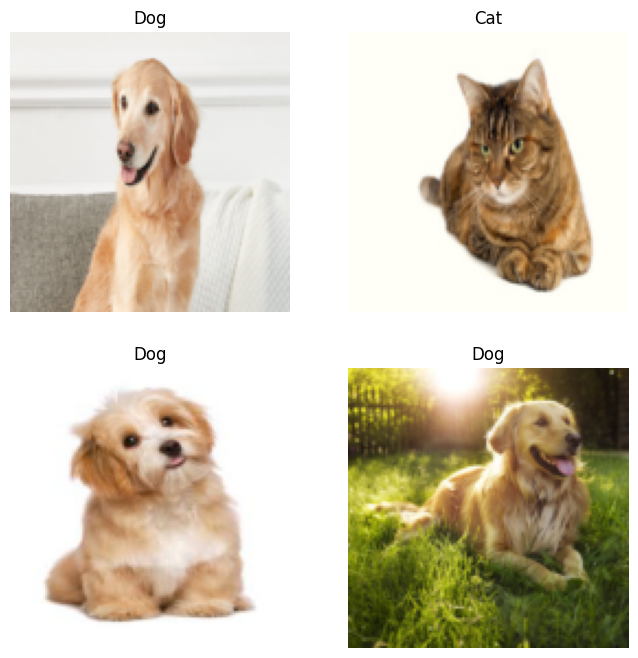

In [14]:
# Visualize the data
import matplotlib.pyplot as plt

to_pil = transforms.ToPILImage()

labels_map = {
    0: "Cat",
    1: "Dog"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cats_dogs_ds), size=(1,)).item()
    img, label = cats_dogs_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(to_pil(img))
plt.show()

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity.

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(cats_dogs_ds, # dataset to iterate
                              batch_size=2, # how many images to load every iteration
                              shuffle=True) # sample data randomly

In [36]:
# iterate trough the dataloader
for i, (img, labels) in enumerate(train_dataloader):
    print("Loaded images of size {} with labels {}".format(img.size(), labels))

print("--------")
# Iterate only once
img, labels = next(iter(train_dataloader))
print("Loaded images of size {} with labels {}".format(img.size(), labels))

Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 1])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 1])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([1, 0])
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 1])
--------
Loaded images of size torch.Size([2, 3, 128, 128]) with labels tensor([0, 0])


## Unlabeled Dataset
Images are in a folder and do not have a particular label.

In [22]:
# Use Custom Dataset
from PIL import Image
from torch.utils.data import Dataset

# Define a function to load images
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
# Alternative: from torchvision.io import read_image

In [32]:
import glob

class PaintingDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.file_list = glob.glob(self.root_dir + "*.jpg") # we want only jpg images

    def __len__(self):
        return len(self.file_list)
    
    # This function is called every time we iterate the dataset
    def __getitem__(self, idx):
        
        img_name = self.file_list[idx]
        image = pil_loader(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [33]:
# Create the dataset
paint_ds = PaintingDataset(
            root_dir='res/custom_dataset/unlabeled_dataset/friedrich_paintings/',
            transform=data_transform)
print(len(paint_ds))

4


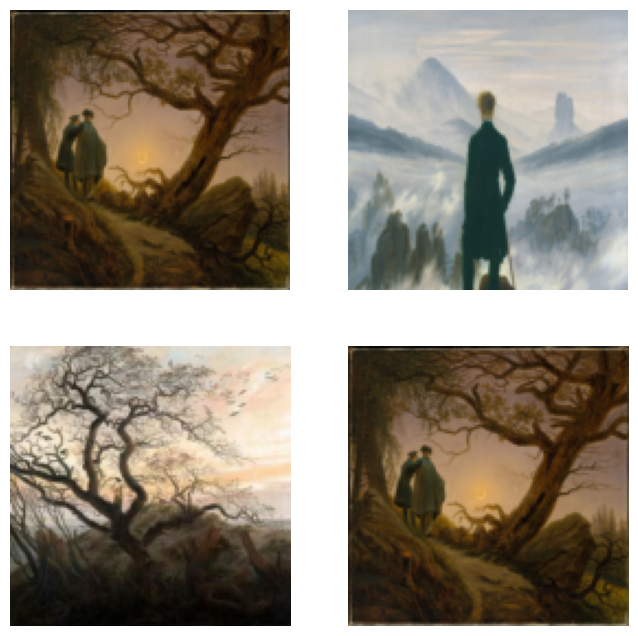

In [34]:
# Visualize the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(paint_ds), size=(1,)).item()
    img = paint_ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(to_pil(img))
plt.show()

In [35]:
# You can then iterate the dataset using a DataLoader as before
paint_dataloader = DataLoader(paint_ds, # dataset to iterate
                              batch_size=2, # how many images to load every iteration
                              shuffle=True) # sample data randomly

for i, (img) in enumerate(paint_dataloader):
    print("Loaded images of size {}".format(img.size()))

Loaded images of size torch.Size([2, 3, 128, 128])
Loaded images of size torch.Size([2, 3, 128, 128])
